# GANDhani: CycleGAN for Cultural Style Transfer Translating Bandhani Textile Motifs to Contemporary Style

### Import Required Libraries

In [1]:
import os
import random
import pathlib
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.transforms import InterpolationMode, functional as TF
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr
%matplotlib inline

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the Dataset

In [2]:
# Authenticate
api = KaggleApi()
api.authenticate()

In [3]:
# Make data directories
base = pathlib.Path('./data')
for split in ['train', 'val']:
    for domain in ['bandhani', 'modern']:
        (base / split / domain).mkdir(parents=True, exist_ok=True)

In [4]:
# Download & unzip into TRAIN folders
api.dataset_download_files(
    "amansunesh/bandhani-design-dataset",
    path=str(base / 'train' / 'bandhani'),
    unzip=True
)

api.dataset_download_files(
    "amansunesh/modern-art-dataset",
    path=str(base / 'train' / 'modern'),
    unzip=True
)

# Now randomly move 10% of each domain into VAL
for domain in ['bandhani', 'modern']:
    all_imgs = list((base / 'train' / domain).glob('*.jpg'))
    
    random.shuffle(all_imgs)
    n_val = int(0.1 * len(all_imgs))

    for img_path in all_imgs[:n_val]:
        dest = base / 'val' / domain / img_path.name
        shutil.move(str(img_path), str(dest))

Dataset URL: https://www.kaggle.com/datasets/amansunesh/bandhani-design-dataset
Dataset URL: https://www.kaggle.com/datasets/amansunesh/modern-art-dataset


### Data Proprocessing

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(286, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
])

In [6]:
class CycleGANDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        base = pathlib.Path(root_dir) / mode
        self.bandhani_paths = sorted((base / "bandhani").glob("*.jpg"))
        self.modern_paths   = sorted((base / "modern").glob("*.jpg"))

        assert len(self.bandhani_paths) and len(self.modern_paths), \
            f"No images found in {base}/bandhani or {base}/modern"
        
        self.transform = transform

    def __len__(self):
        return min(len(self.bandhani_paths), len(self.modern_paths))

    def __getitem__(self, idx):
        path_A = self.bandhani_paths[idx]
        path_B = self.modern_paths[idx]

        img_A = Image.open(path_A).convert("RGB")
        img_B = Image.open(path_B).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

In [7]:
bs = 1
root_dir = "./data"

train_ds = CycleGANDataset(root_dir, mode='train', transform=train_transform)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True)

In [8]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

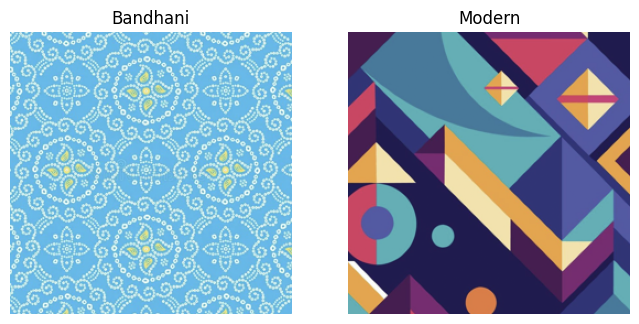

In [9]:
bandhani, modern = train_ds[0]

# Un‐normalize and convert to numpy
bandhani_np = denorm(bandhani).permute(1,2,0).cpu().numpy()
modern_np   = denorm(modern).permute(1,2,0).cpu().numpy()


fig, axes = plt.subplots(1,2, figsize=(8,4))

for ax, img, title in zip(axes, (bandhani_np, modern_np), ('Bandhani','Modern')):
    ax.imshow(img); ax.set_title(title); ax.axis('off')

plt.show()

### Discriminator Network

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, base_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_features, base_features * 2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(base_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_features * 2, base_features * 4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(base_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_features * 4, base_features * 8, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(base_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_features * 8, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

### Generator Network

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x) # Skip Connections

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()

        self.g1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, features, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(features),
            nn.ReLU(True),
        )

        self.g2 = nn.Sequential(
            nn.Conv2d(features, features*2, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(features*2),
            nn.ReLU(True),
        )

        self.g3 = nn.Sequential(
            nn.Conv2d(features*2, features*4, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(features*4),
            nn.ReLU(True),
        )

        res_blocks = []

        for _ in range(9):
            res_blocks.append(ResidualBlock(features*4))
        self.res_blocks = nn.Sequential(*res_blocks)

        self.g4 = nn.Sequential(
            nn.ConvTranspose2d(features*4, features*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(features*2),
            nn.ReLU(True),
        )

        self.g5 = nn.Sequential(
            nn.ConvTranspose2d(features*2, features, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(features),
            nn.ReLU(True),
        )

        self.g6 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(features, out_channels, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        g1 = self.g1(x)
        g2 = self.g2(g1)
        g3 = self.g3(g2)
        res = self.res_blocks(g3)
        g4 = self.g4(res)
        g5 = self.g5(g4)
        
        return self.g6(g5)

### Discriminator Training

In [13]:
def train_discriminator(discriminator_A, discriminator_B,
                        real_A, real_B, 
                        fake_A, fake_B,
                        opt_d, criterion_GAN):
    
    discriminator_A.train()
    discriminator_B.train()

    # Clear discriminator gradients
    opt_d.zero_grad()

    # --- Train D_A ---

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds_A = discriminator_A(real_A)
    real_targets_A = torch.ones_like(real_preds_A)
    loss_D_A_real = criterion_GAN(real_preds_A, real_targets_A)
    real_score_A = real_preds_A.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_preds_A = discriminator_A(fake_A.detach())
    fake_targets_A = torch.zeros_like(fake_preds_A)
    loss_D_A_fake = criterion_GAN(fake_preds_A, fake_targets_A)
    fake_score_A  = fake_preds_A.mean().item()

    loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)


    # --- Train D_B ---

    # ——— Real pairs ———
    # D(map, real) should predict “real” → target=1
    real_preds_B = discriminator_B(real_B)
    real_targets_B = torch.ones_like(real_preds_B)
    loss_D_B_real = criterion_GAN(real_preds_B, real_targets_B)
    real_score_B = real_preds_B.mean().item()

    # ——— Fake pairs ———
    # Generate fake images
    # G(map) → fake; detach so G’s grad isn’t updated here
    fake_preds_B = discriminator_B(fake_B.detach())
    fake_targets_B = torch.zeros_like(fake_preds_B)
    loss_D_B_fake = criterion_GAN(fake_preds_B, fake_targets_B)
    fake_score_B  = fake_preds_B.mean().item()

    loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)


    # --- Total Discriminator Loss ---
    loss_D = loss_D_A + loss_D_B
    loss_D.backward()
    opt_d.step()
    
    return {
        'loss_D_A': loss_D_A.item(),
        'loss_D_B': loss_D_B.item(),
        'real_A_score': real_score_A,
        'fake_A_score': fake_score_A,
        'real_B_score': real_score_B,
        'fake_B_score': fake_score_B
    }

### Generator Training

In [14]:
def train_generator(discriminator_A, discriminator_B,
                        generator_A, generator_B,
                        real_A, real_B, 
                        lambda_a, lambda_b, lambda_id,
                        opt_g, criterion_GAN):
    
    # Clear generator gradients                                     
    opt_g.zero_grad()

    fake_B = generator_A(real_A)
    fake_A = generator_B(real_B)

    # --- Train D_A ---

    # 1) Adverserial Loss
    preds_fake_a = discriminator_A(fake_A)
    targets_a = torch.ones_like(preds_fake_a)
    adv_total_b = criterion_GAN(preds_fake_a, targets_a)

    preds_fake_b = discriminator_B(fake_B)
    targets_b = torch.ones_like(preds_fake_b)
    adv_total_a = criterion_GAN(preds_fake_b, targets_b)

    # 2) Cycle Losses
    rec_A = generator_B(fake_B)
    rec_B = generator_A(fake_A)

    loss_cycle_A = F.l1_loss(rec_A, real_A)
    loss_cycle_B = F.l1_loss(rec_B, real_B)

    # 3) Identity Loss
    idt_B = generator_A(real_B)
    idt_A = generator_B(real_A)
    identity_a = F.l1_loss(idt_B, real_B)
    identity_b = F.l1_loss(idt_A, real_A)

    loss_a = adv_total_a + (lambda_a * loss_cycle_A) + (lambda_id * lambda_b * identity_a)
    loss_b = adv_total_b + (lambda_b * loss_cycle_B) + (lambda_id * lambda_a * identity_b)

    loss_total = loss_a + loss_b
    
    loss_total.backward()
    opt_g.step()

    return {
        'loss_total': loss_total.item(),
        'G_A_loss':   loss_a.item(),
        'G_B_loss':   loss_b.item(),
        'adv_A':      adv_total_a.item(),
        'adv_B':      adv_total_b.item(),
        'cycle_A':    loss_cycle_A.item(),
        'cycle_B':    loss_cycle_B.item(),
        'idt_A':      identity_a.item(),
        'idt_B':      identity_b.item()
    }

In [15]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

### Saving Generated Samples

In [16]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [17]:
def save_cycle_samples(
    epoch: int,
    real_A: torch.Tensor,
    real_B: torch.Tensor,
    generator_A: nn.Module,
    generator_B: nn.Module,
    denorm,
    sample_dir: str = "generated",
    nrow: int = 8
):
    generator_A.eval()
    generator_B.eval()

    with torch.no_grad():
        fake_B = generator_A(real_A.to(next(generator_A.parameters()).device))
        fake_A = generator_B(real_B.to(next(generator_B.parameters()).device))

    # bring back to [0,1]
    real_A_vis = denorm(real_A.cpu())
    real_B_vis = denorm(real_B.cpu())
    fake_A_vis = denorm(fake_A.cpu())
    fake_B_vis = denorm(fake_B.cpu())

    # make grids
    grid_A2B = make_grid(
        torch.cat([real_A_vis, fake_B_vis], dim=0),
        nrow=nrow,
        padding=2,
        normalize=False
    )
    grid_B2A = make_grid(
        torch.cat([real_B_vis, fake_A_vis], dim=0),
        nrow=nrow,
        padding=2,
        normalize=False
    )

    # save
    save_image(grid_A2B, os.path.join(sample_dir, f"A2B_epoch{epoch:03d}.png"))
    save_image(grid_B2A, os.path.join(sample_dir, f"B2A_epoch{epoch:03d}.png"))

### Full Training Loop

In [18]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.data = []
        self.max_size = max_size

    def push_and_pop(self, images):
        out = []
        for img in images:
            img = img.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(img)
                out.append(img)
            else:
                if random.random() < 0.5:
                    i = random.randint(0, self.max_size-1)
                    out.append(self.data[i].clone())
                    self.data[i] = img
                else:
                    out.append(img)
        return torch.cat(out)

In [19]:
epochs = 200

def lambda_rule(epoch):
    # 1.0 for epoch ∈ [0, epochs/2), then linearly to 0 by epoch=epochs
    return 1.0 - max(0, epoch - epochs//2) / float(epochs//2)

In [20]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 1.0, 0.02)
            
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias, 0)

In [ ]:
def fit(
    discriminator_A: nn.Module,
    discriminator_B: nn.Module,
    generator_A:     nn.Module,
    generator_B:     nn.Module,
    train_dl:        DataLoader,
    denorm,
    device:          torch.device,
    epochs:          int      = 300,
    lr:              float    = 2e-4,
    lambda_a:        float    = 10.0,
    lambda_b:        float    = 10.0,
    lambda_id:       float    = 0.5,
    pool_size:       int      = 50,
    sample_dir:      str      = "generated",
    nrow:            int      = 8):
    
    opt_G = torch.optim.Adam(
        list(generator_A.parameters()) + list(generator_B.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    opt_D = torch.optim.Adam(
        list(discriminator_A.parameters()) + list(discriminator_B.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )

    sched_G = torch.optim.lr_scheduler.LambdaLR(opt_G, lr_lambda=lambda_rule)
    sched_D = torch.optim.lr_scheduler.LambdaLR(opt_D, lr_lambda=lambda_rule)

    # grab one fixed batch for visualization 
    fixed_A, fixed_B = next(iter(train_dl))
    fixed_A, fixed_B = fixed_A.to(device), fixed_B.to(device)

    criterion_GAN = nn.MSELoss() # LSGAN
    buffer_A = ReplayBuffer(pool_size)  # for fake_A
    buffer_B = ReplayBuffer(pool_size)  # for fake_B

    # ——— history ———
    history = {
        'G_A': [], 'G_B': [],
        'D_A': [], 'D_B': [],
        'cycle_A': [], 'cycle_B': [],
        'idt_A': [],   'idt_B': [],
        'adv_A': [],   'adv_B': []
    }

    for epoch in range(1, epochs + 1):
        for real_A, real_B in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs}", leave=False):
            real_A, real_B = real_A.to(device), real_B.to(device)

            gen_metrics = train_generator(
                discriminator_A, discriminator_B,
                generator_A, generator_B,
                real_A, real_B,
                lambda_a, lambda_b, lambda_id,
                opt_G, criterion_GAN
            )
            
            # produce fresh fakes (for the buffer)
            fake_B = generator_A(real_A).detach()
            fake_A = generator_B(real_B).detach()

            # ——— 2) Discriminators ———
            # pull from buffer
            fake_A_buf = buffer_A.push_and_pop(fake_A)
            fake_B_buf = buffer_B.push_and_pop(fake_B)

            disc_metrics = train_discriminator(
                discriminator_A, discriminator_B,
                real_A, real_B,
                fake_A_buf, fake_B_buf,
                opt_D, criterion_GAN
            )

            # Log losses & scores
            history['G_A'].append(gen_metrics['G_A_loss'])
            history['G_B'].append(gen_metrics['G_B_loss'])
            history['adv_A'].append(gen_metrics['adv_A'])
            history['adv_B'].append(gen_metrics['adv_B'])
            history['cycle_A'].append(gen_metrics['cycle_A'])
            history['cycle_B'].append(gen_metrics['cycle_B'])
            history['idt_A'].append(gen_metrics['idt_A'])
            history['idt_B'].append(gen_metrics['idt_B'])

            history['D_A'].append(disc_metrics['loss_D_A'])
            history['D_B'].append(disc_metrics['loss_D_B'])

        # Step the schedulers each epoch
        sched_G.step()
        sched_D.step()

        if epoch % 5 == 0:
            torch.save(generator_A.state_dict(), f"checkpoint_gen_a_epoch{epoch}.pth")
            torch.save(generator_B.state_dict(), f"checkpoint_gen_b_epoch{epoch}.pth")

        # every epoch dump sample grids A→B and B→A
        save_cycle_samples(
            epoch,
            fixed_A, fixed_B,
            generator_A, generator_B,
            denorm,
            sample_dir=sample_dir,
            nrow=nrow
        )

        print(f"Epoch {epoch}/{epochs}  "
              f"G_A: {gen_metrics['G_A_loss']:.3f}, "
              f"G_B: {gen_metrics['G_B_loss']:.3f}, "
              f"D_A: {disc_metrics['loss_D_A']:.3f}, "
              f"D_B: {disc_metrics['loss_D_B']:.3f}")

    return history


: 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

discriminator_a = Discriminator().to(device)
discriminator_b = Discriminator().to(device)
generator_a     = Generator().to(device)
generator_b     = Generator().to(device)

generator_a.apply(init_weights)
generator_b.apply(init_weights)
discriminator_a.apply(init_weights)
discriminator_b.apply(init_weights)

history = fit(
    discriminator_A=discriminator_a,
    discriminator_B=discriminator_b,
    generator_A=generator_a,
    generator_B=generator_b,
    train_dl=train_dl,
    denorm=denorm,
    device=device
)

Epoch 1/300:   0%|          | 1/499 [00:30<4:09:44, 30.09s/it]

In [ ]:
losses_G_A = history['G_A']
losses_G_B = history['G_B']
losses_D_A = history['D_A']
losses_D_B = history['D_B']
adv_A      = history['adv_A']
adv_B      = history['adv_B']
cycle_A    = history['cycle_A']
cycle_B    = history['cycle_B']
idt_A      = history['idt_A']
idt_B      = history['idt_B']

### Checkpointing

In [ ]:
# Save the model checkpoints 
torch.save(generator_a.state_dict(), 'G_a.pth')
torch.save(generator_b.state_dict(), 'G_b.pth')
torch.save(discriminator_a.state_dict(), 'D_a.pth')
torch.save(discriminator_b.state_dict(), 'D_b.pth')

In [ ]:
def display_epoch_images(epoch, sample_dir='generated'):
    a2b_file = os.path.join(sample_dir, f"A2B_epoch{epoch:03d}.png")
    b2a_file = os.path.join(sample_dir, f"B2A_epoch{epoch:03d}.png")
    
    # load images
    img_a2b = Image.open(a2b_file)
    img_b2a = Image.open(b2a_file)
    
    # plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_a2b)
    axes[0].set_title(f"Epoch {epoch}: A → B")
    axes[0].axis('off')
    
    axes[1].imshow(img_b2a)
    axes[1].set_title(f"Epoch {epoch}: B → A")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Here's how the generated images look, after the 1st, 10th, 50th, 100th, 150th, 200th, 2500th, and 300th epochs of training.

In [ ]:
for e in [1, 10, 50, 199, 150, 200, 250, 300]:
    display_epoch_images(e)

### Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_D_A) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_D_A, label="Discriminator_A")
plt.plot(epochs_range, losses_G_A, label="Generator_A")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_D_B, label="Discriminator_B")
plt.plot(epochs_range, losses_G_B, label="Generator_B")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

### Plotting Adverserial Losses

In [ ]:
plt.clf()
plt.plot(epochs_range, adv_A, label ="Adv Loss A→B")
plt.plot(epochs_range, adv_B, label="Adv Loss B→A")
plt.xlabel("Iteration")
plt.ylabel("Adversarial Loss")
plt.legend()
plt.show()

### Plotting Cycle-Consistency Losses

In [ ]:
plt.clf()
plt.plot(epochs_range, cycle_A, label ="Cycle Loss A→A")
plt.plot(epochs_range, cycle_B, label="Cycle Loss B→B")
plt.xlabel("Iteration")
plt.ylabel("Cycle-consistency Loss")
plt.legend()
plt.show()

### Plotting Identity Losses

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(epochs_range, idt_A, label="Identity Loss A", linewidth=2)
plt.plot(epochs_range, idt_B, label="Identity Loss B", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Identity Loss")
plt.title("Identity Losses over Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

# Primary axis: cycle losses (often larger)
ax1.plot(epochs_range, cycle_A,  'C1-', label="Cycle Loss A")
ax1.plot(epochs_range, cycle_B,  'C2-', label="Cycle Loss B")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cycle Loss")

# Secondary axis: identity losses (much smaller)
ax2 = ax1.twinx()
ax2.plot(epochs_range, idt_A,   'C3--', label="Identity Loss A")
ax2.plot(epochs_range, idt_B,   'C4--', label="Identity Loss B")
ax2.set_ylabel("Identity Loss")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Cycle vs. Identity Loss (A & B)")
plt.grid(True, which="both", axis="x")
plt.show()

###  Generating New Images

In [ ]:
val_ds = CycleGANDataset(root_dir='data', mode='val', transform=train_transform)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen_A2B = Generator().to(device)
gen_B2A = Generator().to(device)
gen_A2B.load_state_dict(torch.load('checkpoint_gen_a_epoch300.pth'))
gen_B2A.load_state_dict(torch.load('checkpoint_gen_a_epoch300.pth'))
gen_A2B.eval()
gen_B2A.eval()

In [ ]:
real_A, real_B = next(iter(val_dl))
real_A, real_B = real_A.to(device), real_B.to(device)

with torch.no_grad():
    fake_B = gen_A2B(real_A)
    fake_A = gen_B2A(real_B)

In [ ]:
real_A = denorm(real_A)[:16]
fake_B = denorm(fake_B)[:16]
real_B = denorm(real_B)[:16]
fake_A = denorm(fake_A)[:16]

In [ ]:
# Interleave Real vs. Fake pairs for each domain
# Resulting shape = [32, C, H, W]
pairs_A2B = torch.stack([real_A, fake_B], dim=1).reshape(-1, *real_A.shape[1:])
pairs_B2A = torch.stack([real_B, fake_A], dim=1).reshape(-1, *real_B.shape[1:])

# Make grids (8 columns × 4 rows)
grid_A2B = make_grid(pairs_A2B, nrow=8, padding=2)
grid_B2A = make_grid(pairs_B2A, nrow=8, padding=2)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# A -> B
axes[0].imshow(grid_A2B.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("A → B: [Real A, Fake B] pairs", fontsize=16)
axes[0].axis('off')

# B -> A
axes[1].imshow(grid_B2A.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("B → A: [Real B, Fake A] pairs", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### User Interface

In [ ]:
def translate_A2B(img: Image.Image) -> Image.Image:
    x = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        fake = gen_A2B(x)

    out = denorm(fake[0]).clamp(0,1)

    return transforms.ToPILImage()(out.cpu())


def translate_B2A(img: Image.Image) -> Image.Image:
    x = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        fake = gen_B2A(x)

    out = denorm(fake[0]).clamp(0,1)

    return transforms.ToPILImage()(out.cpu())

In [ ]:
# Build Gradio app with two tabs
with gr.Blocks(title="CycleGAN Translator") as demo:
    gr.Markdown("## CycleGAN: A ↔ B Image Translation")

    with gr.Tab("A → B"):
        inp_ab = gr.Image(label="Input A", type="pil")
        out_ab = gr.Image(label="Generated B")
        btn_ab = gr.Button("Generate A→B")
        btn_ab.click(fn=translate_A2B, inputs=inp_ab, outputs=out_ab)

    with gr.Tab("B → A"):
        inp_ba = gr.Image(label="Input B", type="pil")
        out_ba = gr.Image(label="Generated A")
        btn_ba = gr.Button("Generate B→A")
        btn_ba.click(fn=translate_B2A, inputs=inp_ba, outputs=out_ba)

    gr.Markdown("Upload an image and choose the tab for the direction you want.")

In [ ]:
# Launch
demo.launch(share=True)